In [1]:
# Standard Python modules
import os, sys
import yaml
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
import matplotlib.ticker as mticker
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes

# Extra 
from scipy.ndimage import gaussian_filter    # smoothing contour lines
from scipy import stats

import metpy.calc as mpcalc
from metpy.units import units
from IPython.display import Image, display

# import personal modules

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap
from timeseries import persistence, select_months, create_list_all_dates
from teleconnections import build_teleconnection_df
from statistical_tests import build_zscore_df, ttest_1samp_new

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures

# USE pandas.options TO DISPLAY FLOATS TO TWO DECIMAL PLACES
pd.options.display.float_format = "{:,.2f}".format

In [3]:
ceofid = 'HUV500'
neofs = 2 # choose number of eofs
nk = 3 # choose number of clusters

In [4]:
def ar_daily_df(ssn, nk):
    out_path = path_to_out + ceofid + '/' + ssn + '/' + 'neof' + str(neofs) + '/k' + str(nk) + '/'
    filepath = out_path + 'AR-types_ALLDAYS.csv'
    df = pd.read_csv(filepath)

    # set up datetime index
    df = df.rename(columns={'Unnamed: 0': 'date'})
    df = df.set_index(pd.to_datetime(df.date))
    
    ## Break up columns into different AR Types
    keys = []
    for k in range(nk):
        keys.append("AR_CAT{:1d}".format(k+1,))

    values = np.zeros((len(df.index)))
    dicts = dict(zip(keys, values))

    df_cat = pd.DataFrame(dicts, index=df.index)

    for k in range(nk):
        idx = (df['AR_CAT'] == k+1)
        col = "AR_CAT{:1d}".format(k+1,)
        df_cat.loc[idx, col] = 1
        
    # get total of all AR types
    df_cat['AR_ALL'] = df_cat['AR_CAT1'] + df_cat['AR_CAT2'] + df_cat['AR_CAT3']
    df_cat['AR_CAT'] = df['AR_CAT']
    
    return df_cat

In [5]:
# tele index
start_date = '1979-12-01'
end_date = '2019-05-31'

tele = build_teleconnection_df('daily', 'COND', start_date, end_date)
df_index_djfmam = select_months(tele, 12, 5)

# AR df
df_djfmam = ar_daily_df(ssn='djfmam', nk=3)

# combine ar df with tele df
print(len(df_djfmam), len(df_index_djfmam))
# join indices with AR count
new_djfmam = df_djfmam.join(df_index_djfmam)
new_djfmam

7290 7290


,AR_CAT1,AR_CAT2,AR_CAT3,AR_ALL,AR_CAT,AO,PDO,ENSO,SH
date,,,,,,,,,
1979-12-01 09:00:00,0.00,0.00,1.00,1.00,3,1,0,0,0
1979-12-02 09:00:00,0.00,0.00,1.00,1.00,3,1,0,0,0
1979-12-03 09:00:00,0.00,0.00,0.00,0.00,0,1,0,0,0
1979-12-04 09:00:00,0.00,0.00,0.00,0.00,0,1,0,0,0
1979-12-05 09:00:00,0.00,0.00,0.00,0.00,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
2019-05-27 09:00:00,0.00,0.00,0.00,0.00,0,0,0,1,1
2019-05-28 09:00:00,0.00,0.00,0.00,0.00,0,-1,0,1,1
2019-05-29 09:00:00,0.00,0.00,0.00,0.00,0,-1,0,1,1


### Run zscore difference in proportion tests

In [34]:
# positive vs. negative
zscore_djfmam = build_zscore_df(new_djfmam)
zscore_djfmam[0]

zstat  pval
Teleconnection AR Type             
AO             AR_CAT1   1.95  0.05
               AR_CAT2  -1.06  0.29
               AR_CAT3   6.62  0.00
               AR_ALL    4.68  0.00
PDO            AR_CAT1   1.17  0.24
               AR_CAT2   2.36  0.02
               AR_CAT3   1.59  0.11
               AR_ALL    3.07  0.00
ENSO           AR_CAT1   1.06  0.29
               AR_CAT2   1.59  0.11
               AR_CAT3   4.93  0.00
               AR_ALL    4.71  0.00
SH             AR_CAT1  -0.16  0.87
               AR_CAT2  -0.92  0.36
               AR_CAT3  -4.06  0.00
               AR_ALL   -3.34  0.00

In [35]:
# positive vs. neutral
zscore_djfmam[1]

zstat  pval
Teleconnection AR Type             
AO             AR_CAT1   1.14  0.25
               AR_CAT2   0.60  0.55
               AR_CAT3   3.52  0.00
               AR_ALL    3.38  0.00
PDO            AR_CAT1   1.83  0.07
               AR_CAT2   0.12  0.90
               AR_CAT3  -1.74  0.08
               AR_ALL   -0.11  0.91
ENSO           AR_CAT1   1.11  0.27
               AR_CAT2  -0.33  0.74
               AR_CAT3   2.26  0.02
               AR_ALL    1.89  0.06
SH             AR_CAT1   0.07  0.94
               AR_CAT2  -1.48  0.14
               AR_CAT3   0.47  0.64
               AR_ALL   -0.61  0.54

In [36]:
# negative vs. neutral
zscore_djfmam[2]

zstat  pval
Teleconnection AR Type             
AO             AR_CAT1  -0.83  0.41
               AR_CAT2   1.65  0.10
               AR_CAT3  -3.30  0.00
               AR_ALL   -1.36  0.17
PDO            AR_CAT1   0.60  0.55
               AR_CAT2  -2.38  0.02
               AR_CAT3  -3.45  0.00
               AR_ALL   -3.39  0.00
ENSO           AR_CAT1  -0.17  0.86
               AR_CAT2  -2.12  0.03
               AR_CAT3  -3.55  0.00
               AR_ALL   -3.64  0.00
SH             AR_CAT1   0.23  0.82
               AR_CAT2  -0.64  0.52
               AR_CAT3   4.18  0.00
               AR_ALL    2.51  0.01

### Bar Plot Fractions

AR frequency is calculated as the percent AR days out of all days in a given AO, ENSO, SH, or PDO phase during December–March

e.g. (number of AR days/number of days in El Nino phase) vs. (number of AR days/# of days in Neutral)

In [44]:
cols = ['AR_CAT1', 'AR_CAT2', 'AR_CAT3', 'AR_ALL']
djfmam = new_djfmam.drop(columns=cols)
results_test = []
for i, df in enumerate([djfmam]):
    test_df = df
    print(len(test_df))
    # count the frequency of each AR type based on phase conditions
    test = test_df.groupby(['AR_CAT']).agg({'AO': 'value_counts',
                                        'PDO': 'value_counts',
                                        'ENSO': 'value_counts',
                                        'SH': 'value_counts'})
    print(test)
    test3 = test_df.agg({'AO': 'value_counts',
                                        'PDO': 'value_counts',
                                        'ENSO': 'value_counts',
                                        'SH': 'value_counts'})
    test3 = pd.concat([test3]*4, keys=[0, 1, 2, 3])
    print(test3)
    # get the frequency value
    test2 = test.div(test3, axis=0)
    print(test2)

    # put into a new dataframe and reset the index
    data=pd.DataFrame(test2*100)
    data = data.reset_index()

    # melt the dataframe to make it tidy
    results = pd.melt(data, id_vars=['level_0', 'level_1'], value_vars=['AO', 'PDO', 'ENSO', 'SH'],
                      var_name='teleconnection', value_name='frequency')

    # drop rows where level_0 = 0
    # or where there is no AR
    results_test.append(results[results.level_0 != 0])

7290
        AO   PDO  ENSO    SH
0 -1  2136  2112  1489  2403
   0  2216  2556  3550  1809
   1  2179  1863  1492  2319
1 -1    55    63    42    78
   0    67    71   107    55
   1    82    70    55    71
2 -1    94    62    43    98
   0    77   112   152    79
   1    86    83    62    80
3 -1    52    71    36   153
   0    95   144   167    61
   1   151    83    95    84
        AO   PDO  ENSO    SH
0 -1  2337  2308  1610  2732
   0  2455  2883  3976  2004
   1  2498  2099  1704  2554
1 -1  2337  2308  1610  2732
   0  2455  2883  3976  2004
   1  2498  2099  1704  2554
2 -1  2337  2308  1610  2732
   0  2455  2883  3976  2004
   1  2498  2099  1704  2554
3 -1  2337  2308  1610  2732
   0  2455  2883  3976  2004
   1  2498  2099  1704  2554
       AO  PDO  ENSO   SH
0 -1 0.91 0.92  0.92 0.88
   0 0.90 0.89  0.89 0.90
   1 0.87 0.89  0.88 0.91
1 -1 0.02 0.03  0.03 0.03
   0 0.03 0.02  0.03 0.03
   1 0.03 0.03  0.03 0.03
2 -1 0.04 0.03  0.03 0.04
   0 0.03 0.04  0.04 0.04
   1 0.

In [19]:
# # put into a new dataframe and reset the index
# djfmamdata=pd.DataFrame(zscore_djfmam)
# djfmamdata = djfmamdata.reset_index()

/home/nash/DATA/repositories/AR_types/figs/zscore_barplot.png


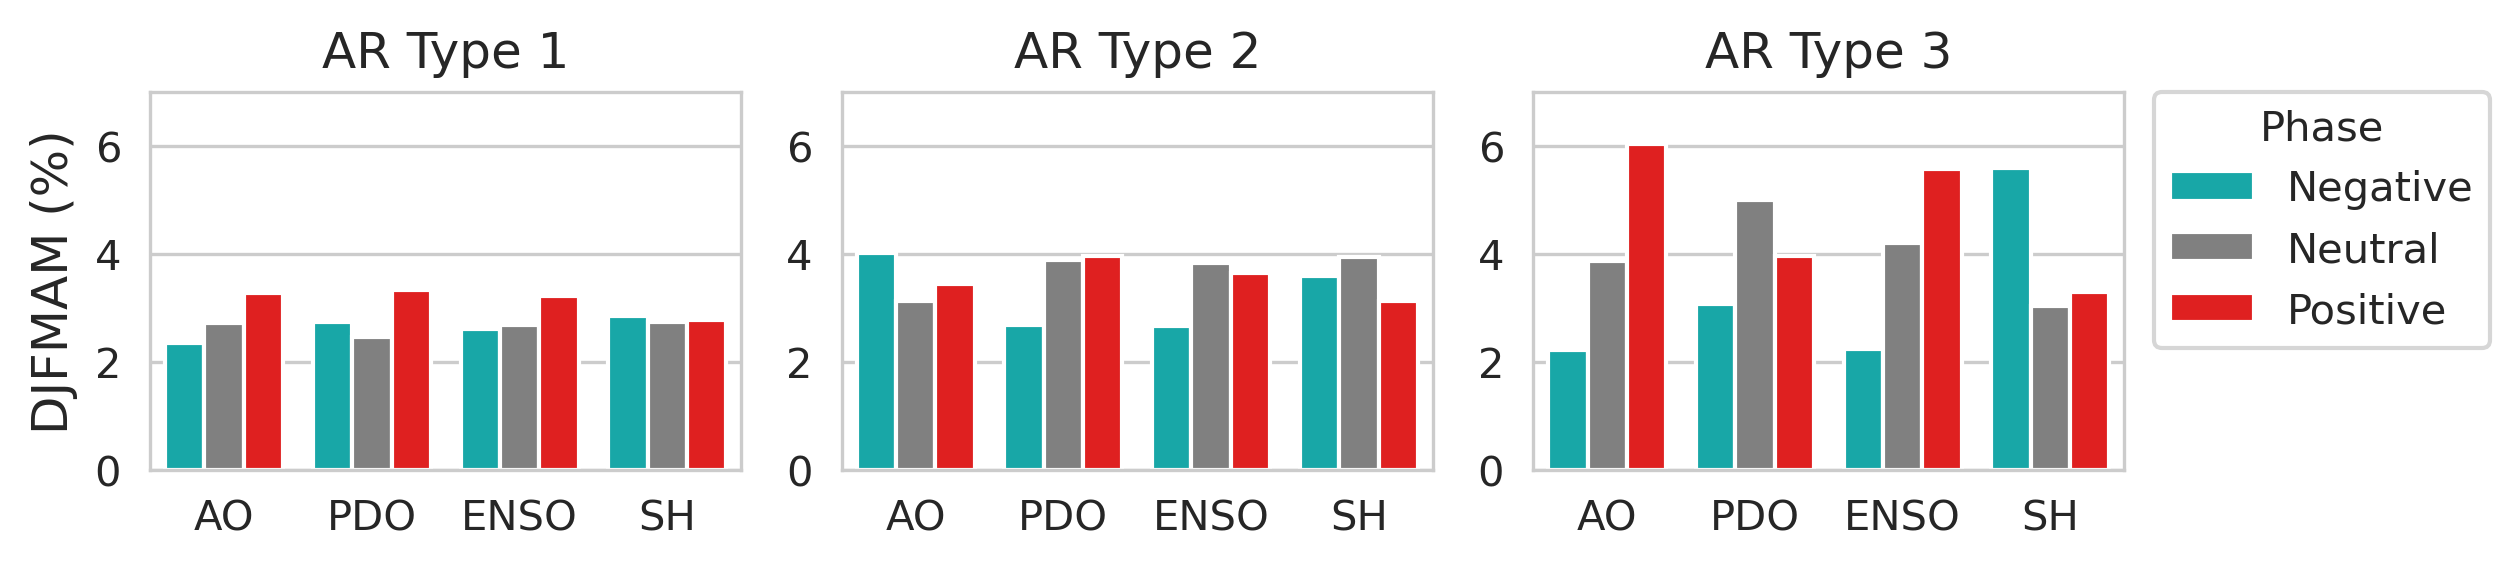

<Figure size 2550x600 with 0 Axes>

In [47]:
# TO DO: add pvalues to x-axis labels
fname = path_to_figs + 'zscore_barplot'
fmt = 'png'
fig = plt.figure()
fig.set_size_inches((8.5,2.0))
fig.dpi = 300
nrows = 1
ncols = 3
nplots=nrows*ncols

artype = [1, 2, 3]
typ_label = ['AR Type 1', 'AR Type 2', 'AR Type 3']
flatui = ['c', 'grey', 'red', ]
row_lbl1 = ['DJFMAM (%)', '', '']

sns.set_style("whitegrid")

#### DJFMAM Plots
for i, (p, ar) in enumerate(zip(np.arange(0, 3), artype)):
    sns.set_style("whitegrid")
    data = results_test[0]
    ax = plt.subplot(nrows, ncols, p+1)
    df = data[data.level_0 == ar]
    g = sns.barplot(x=df['teleconnection'], y=df['frequency'], hue=df["level_1"],
                data=df, palette=flatui, dodge=True, ci=None)
#     for p in g.patches[:4]:
#         g.annotate("$p$=" + format(p.get_height(), '.1f'), 
#                    (p.get_x() + p.get_width() / 2., p.get_height()), 
#                    ha = 'center', va = 'center',
#                    size=6,
#                    xytext = (0, 9), 
#                    textcoords = 'offset points')
    
    g.legend_.remove()
    sns.set_style("ticks")
    ax.set_ylabel(row_lbl1[i], fontsize=12)
    ax.set_xlabel('')
    plt.ylim(0, 7)
    ax.set_title(typ_label[i], loc='center')

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., labels=['Negative', 'Neutral', 'Positive'], title='Phase')
    

plt.tight_layout()
# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()

plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))

1
2
3
/home/nash/DATA/repositories/AR_types/figs/zscore_barplot.png


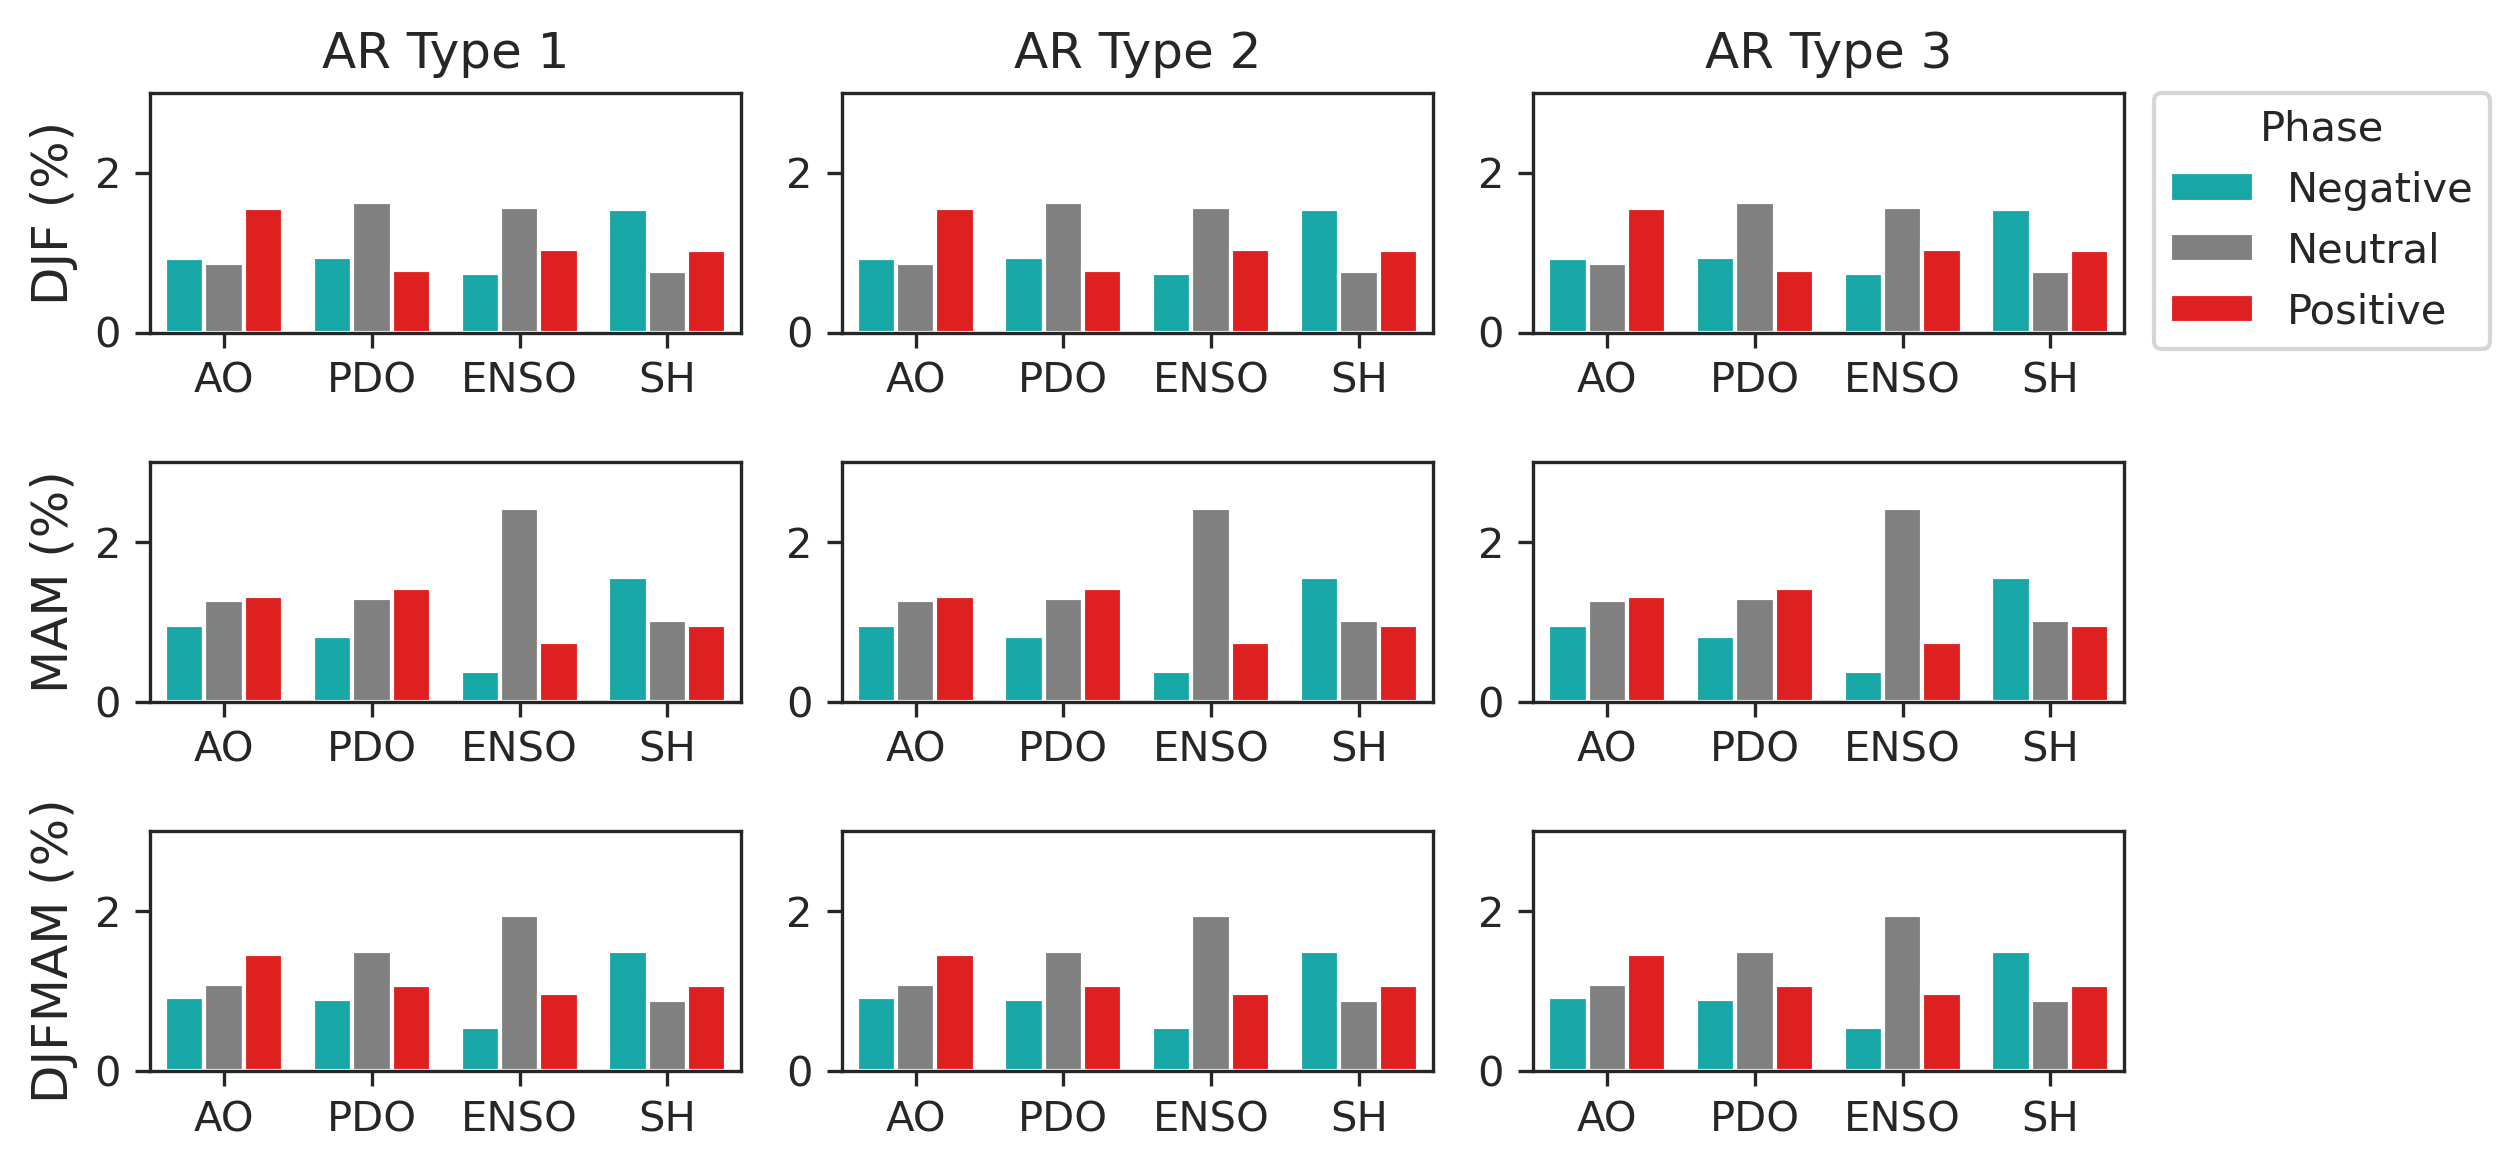

<Figure size 2550x1200 with 0 Axes>

In [21]:
# TO DO: add pvalues to x-axis labels
fname = path_to_figs + 'zscore_barplot'
fmt = 'png'
fig = plt.figure()
fig.set_size_inches((8.5,4.0))
fig.dpi = 300
nrows = 3
ncols = 3
nplots=nrows*ncols

artype = [1, 2, 3]
typ_label = ['AR Type 1', 'AR Type 2', 'AR Type 3']
flatui = ['c', 'grey', 'red', ]
ssn_lst = ['DJF', 'MAM', 'DJFMAM']
row_lbl1 = ['DJF (%)', '', '']
row_lbl2 = ['MAM (%)', '', '']
row_lbl3 = ['DJFMAM (%)', '', '']

#### DJF Plots
for i, (p, ar) in enumerate(zip(np.arange(0, 3), artype)):
    print(ar)
    data = results_test[0]
    ax = plt.subplot(nrows, ncols, p+1)
    df = data[data.level_0 == ar]
    g = sns.barplot(x=data['teleconnection'], y=data['frequency'], hue=data["level_1"],
                data=df, palette=flatui, dodge=True, ci=None)
#     for p in g.patches[:4]:
#         g.annotate("$p$=" + format(p.get_height(), '.1f'), 
#                    (p.get_x() + p.get_width() / 2., p.get_height()), 
#                    ha = 'center', va = 'center',
#                    size=6,
#                    xytext = (0, 9), 
#                    textcoords = 'offset points')
    
    g.legend_.remove()
    sns.set_style("ticks")
    ax.set_ylabel(row_lbl1[i], fontsize=12)
    ax.set_xlabel('')
    plt.ylim(0, 3)
    ax.set_title(typ_label[i], loc='center')

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., labels=['Negative', 'Neutral', 'Positive'], title='Phase')
    
### MAM Plots
for i, (p, ar) in enumerate(zip(np.arange(3, 6), artype)):
    data = results_test[1]
    ax = plt.subplot(nrows, ncols, p+1)
    df = data[data.level_0 == ar]
    g = sns.barplot(x=data['teleconnection'], y=data['frequency'], hue=data["level_1"],
                data=df, palette=flatui, dodge=True, ci=None)
    g.legend_.remove()
    sns.set_style("ticks")
    ax.set_ylabel(row_lbl2[i], fontsize=12)
    ax.set_xlabel('')
    plt.ylim(0, 3)
    
### DJFMAM Plots
for i, (p, ar) in enumerate(zip(np.arange(6, 9), artype)):
    data = results_test[2]
    ax = plt.subplot(nrows, ncols, p+1)
    df = data[data.level_0 == ar]
    g = sns.barplot(x=data['teleconnection'], y=data['frequency'], hue=data["level_1"],
                data=df, palette=flatui, dodge=True, ci=None)
    g.legend_.remove()
    sns.set_style("ticks")
    ax.set_ylabel(row_lbl3[i], fontsize=12)
    ax.set_xlabel('')
    plt.ylim(0, 3)

plt.tight_layout()
# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()

plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))

### Composite Plots

In [16]:
# Select lat/lon grid
lonmin = -180
lonmax = 180
latmin = 0
latmax = 90

def preprocess(ds):
    '''keep only selected lats and lons'''
    return ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))

# # open HUV data
filepath_pattern = path_to_data + 'ERA5/huv/anomalies/daily_filtered_anomalies_*.nc'  
    
f2 = xr.open_mfdataset(filepath_pattern, preprocess=preprocess, combine='by_coords')


# Create new dataset to rename lat lon
var_dict = {'H': (['time', 'lat', 'lon'], f2['z'].values/(9.80665)), # convert to geopotential height (m)
            'U': (['time', 'lat', 'lon'], f2['u'].values),
            'V': (['time', 'lat', 'lon'], f2['v'].values)}
ds = xr.Dataset(var_dict,
                coords={'time': (['time'], f2.time.values),
                        'lat': (['lat'], f2.latitude.values),
                        'lon': (['lon'], f2.longitude.values)})

print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
ds

ds size in GB 46.84



<xarray.Dataset>
Dimensions:  (lat: 181, lon: 720, time: 14975)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01T09:00:00 ... 2019-12-31T09:00:00
  * lat      (lat) float32 90.0 89.5 89.0 88.5 88.0 87.5 ... 2.0 1.5 1.0 0.5 0.0
  * lon      (lon) float32 -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
Data variables:
    H        (time, lat, lon) float64 53.21 53.21 53.21 ... 37.81 37.48 36.82
    U        (time, lat, lon) float64 -1.943e-06 -1.943e-06 ... -0.01631 -0.5869
    V        (time, lat, lon) float64 -0.0005807 -0.0005807 ... 0.8555 0.8648

In [17]:
ssn = 'djfmam'

if ssn == 'djf':
    start_date = '1979-12-01 09:00'
    end_date = '2019-02-28 09:00'
    mon_s = 12
    mon_e = 2
    df = new_djf
elif ssn == 'mam':
    start_date = '1979-03-01 09:00'
    end_date = '2019-05-31 09:00'
    mon_s = 3
    mon_e = 5
    df = new_mam
elif ssn == 'djfmam':
    start_date = '1979-12-01 09:00'
    end_date = '2019-05-31 09:00'
    mon_s = 12
    mon_e = 5
    df = new_djfmam

# Trim date range
idx = slice(start_date, end_date)
ds = ds.sel(time=idx)

# Select months
if mon_s > mon_e:
    idx = (ds.time.dt.month >= mon_s) | (ds.time.dt.month <= mon_e)
else:
    idx = (ds.time.dt.month >= mon_s) & (ds.time.dt.month <= mon_e)
    
ds = ds.sel(time=idx)

# Combine AR Cat data w/ reanalysis data
# Add ar time series to the ERA dataset
cols = ['AR_CAT', 'AO', 'PDO', 'ENSO', 'SH']
for i, col in enumerate(cols):
    ds[col] = ('time', df[col])

ds = ds.set_coords(tuple(cols))
ds

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 720, time: 7290)
Coordinates:
  * time     (time) datetime64[ns] 1979-12-01T09:00:00 ... 2019-05-31T09:00:00
  * lat      (lat) float32 90.0 89.5 89.0 88.5 88.0 87.5 ... 2.0 1.5 1.0 0.5 0.0
  * lon      (lon) float32 -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
    AR_CAT   (time) int64 3 3 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    AO       (time) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... nan nan nan nan nan nan
    PDO      (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan nan
    ENSO     (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan nan
    SH       (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan nan
Data variables:
    H        (time, lat, lon) float64 -183.4 -183.4 -183.4 ... 9.497 9.448 9.42
    U        (time, lat, lon) float64 -1.349e-05 -1.349e-05 ... -3.557 -3.675
    V        (time, lat, lon) float64 -0.0005817 -0.0005817 ... -0.1107 -0.2285

In [18]:
# idx = (ds['AO'] == 1)
# tmp = ds.sel(time=idx)

# # make time series of [0, 1, 0, 0] for dates where conditions are met
# date_lst = tmp.time.values
# df_tmp = create_list_all_dates('1979-03-01 09:00', '2018-05-31 09:00', date_lst)
# df_tmp

# # calculate number of independent events
# event_id, nevents, duration = persistence(df_tmp)


# mean, tval = ttest_1samp(a=tmp, popmean=np.zeros([len(tmp.lat), len(tmp.lon)]), dim='time', n=70)

In [19]:
cols = ['AO', 'PDO', 'ENSO', 'SH']
popmean=np.zeros([len(ds.lat), len(ds.lon)])
data_lst = []
tval_lst = []

for i, tele in enumerate(cols):
    # all days positive teleconnection
    idx = (ds[tele] == 1)
    tmp = ds.sel(time=idx)
    # make time series of [0, 1, 0, 0] for dates where conditions are met
    date_lst = tmp.time.values
    df_tmp = create_list_all_dates(start_date, end_date, date_lst)
    # calculate number of independent events
    event_id, nevents, duration = persistence(df_tmp)
    
    # calculate t-value based on nevents
    a_mean, tval_mask = ttest_1samp_new(a=tmp, popmean=popmean, dim='time', n=nevents)
    data_lst.append(a_mean)
#     tval_lst.append(np.ones(tval_mask.shape, dtype=bool)) # make a tval mask with all True
    tval_lst.append(tval_mask)
    idx_lst = [(tmp['AR_CAT'] > 0),  (tmp['AR_CAT'] == 1),  (tmp['AR_CAT'] == 2),  (tmp['AR_CAT'] == 3)]
    
    # repeat for each AR Type Grouping
    for j, idx in enumerate(idx_lst):
        tmp_ar = tmp.sel(time=idx_lst[j])
        
        # make time series of [0, 1, 0, 0] for dates where conditions are met
        date_lst = tmp_ar.time.values
        df_tmp = create_list_all_dates(start_date, end_date, date_lst)

        # calculate number of independent events
        event_id, nevents, duration = persistence(df_tmp)

        # calculate t-value based on nevents
        a_mean, tval_mask = ttest_1samp_new(a=tmp_ar, popmean=popmean, dim='time', n=nevents)
        data_lst.append(a_mean)
        tval_lst.append(tval_mask)

In [20]:
# Set seaborn plot style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# Set up projection
mapcrs = ccrs.NorthPolarStereo()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+20,20)

# # cmap with white in the middle
# n=50
# x = 0.25
# lower = plt.cm.seismic(np.linspace(0, x, n))
# white = plt.cm.seismic(np.ones(100)*0.25)
# upper = plt.cm.seismic(np.linspace(1-x, 1, n))
# colors = np.vstack((lower, white, upper))
# tmap = mpl.colors.LinearSegmentedColormap.from_list('terrain_map_white', colors)

In [21]:
data_lst[0]

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 720)
Coordinates:
  * lat      (lat) float32 90.0 89.5 89.0 88.5 88.0 87.5 ... 2.0 1.5 1.0 0.5 0.0
  * lon      (lon) float32 -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
Data variables:
    H        (lat, lon) float64 -57.44 -57.44 -57.44 ... -1.035 -1.031 -1.034
    U        (lat, lon) float64 5.751e-07 5.751e-07 5.751e-07 ... 0.4978 0.4972
    V        (lat, lon) float64 -2.88e-05 -2.88e-05 ... 0.04104 0.04836

/home/sbarc/students/nash/miniconda3/envs/ar_types/lib/python3.7/site-packages/matplotlib/contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/sbarc/students/nash/miniconda3/envs/ar_types/lib/python3.7/site-packages/matplotlib/contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


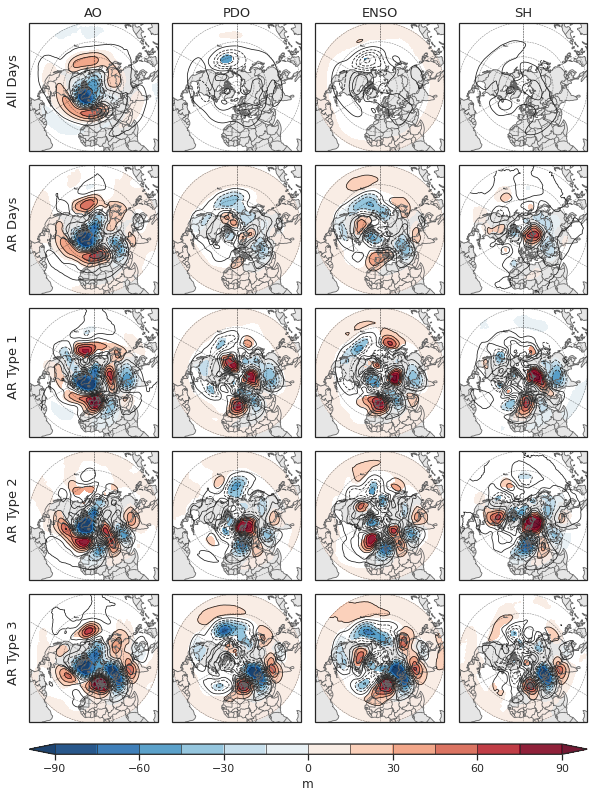

In [22]:
fig_path = path_to_figs + ceofid + '/' + ssn + '/'+ 'neof' + str(neofs) + '/k' + str(nk) + '/'
filepath = fig_path + 'composite_teleconnection_H.png'    
nrows = 5
ncols = 4

cols = ['AO', 'PDO', 'ENSO', 'SH']
plt_lbls = ['AO']+['']*4 + ['PDO']+['']*4 +['ENSO']+['']*4 + ['SH']+['']*4
row_lbl1 = ['All Days','AR Days','AR Type 1','AR Type 2', 'AR Type 3']+ ['']*15

# Create figure
fig = plt.figure(figsize=(10,15))

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.2,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.10, cbar_size='2%',label_mode='',
                direction='column')

for k, ax in enumerate(axgr): 
    # data for plotting
    data = data_lst[k]
    tval = tval_lst[k]
    
    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values 
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], grid=True)
    
    # Contour Filled (mask==True) (only significant values)
    hgts_mask = data.H.where(tval.H == True).values #convert to decimeters
#     hgts = data
    cflevs = np.arange(-90, 95, 15)
    cf = ax.contourf(lons, lats, hgts_mask, transform=datacrs,
                     levels=cflevs, cmap='RdBu_r', alpha=0.9, extend='both')
    
#     # Contour (ALL)
#     hgts_mask = data.where(tval_mask == False)
#     cf_mask = ax.contourf(lons, lats, hgts_mask, transform=datacrs,
#                      levels=cflevs, cmap=cmap, alpha=0.25, extend='both')

    hgts = data.H.values
    clevs = np.arange(-60, 65, 15)
    cs = ax.contour(lons, lats, hgts, transform=datacrs,
                    levels=clevs, colors='k', linewidths=0.75)
#     plt.clabel(cs, fmt='%d',fontsize=8.5, inline_spacing=5) 
    
    # plot titles
    ax.set_title(plt_lbls[k], fontsize=13)
    # Row labels
    ax.text(-0.07, 0.55, row_lbl1[k], va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=13,
        transform=ax.transAxes)
                  
# # Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True, spacing='uniform')
cb.set_label('m')
    
# Save figure
plt.savefig(filepath, dpi=150, bbox_inches='tight')

# Show
plt.show()

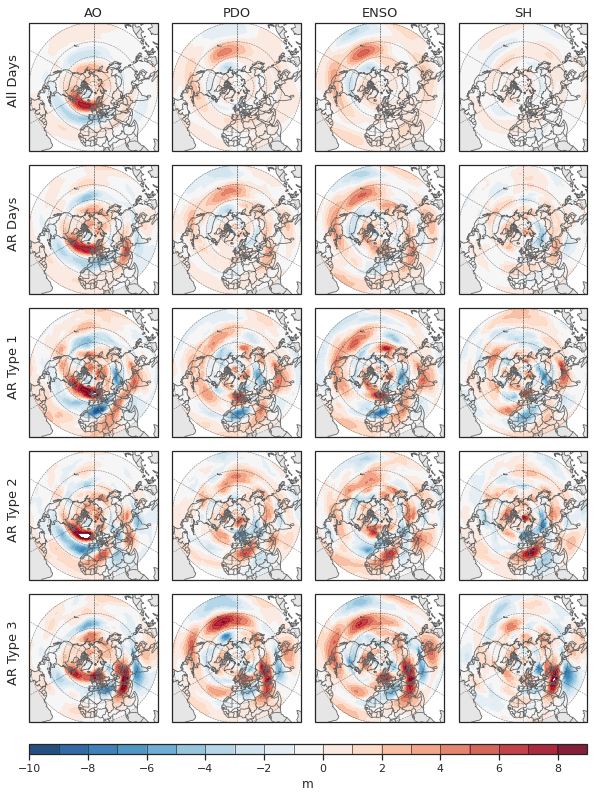

In [23]:
fig_path = path_to_figs + ceofid + '/' + ssn + '/'+ 'neof' + str(neofs) + '/k' + str(nk) + '/'
filepath = fig_path + 'composite_teleconnection_U.png'    
nrows = 5
ncols = 4

cols = ['AO', 'PDO', 'ENSO', 'SH']
plt_lbls = ['AO']+['']*4 + ['PDO']+['']*4 +['ENSO']+['']*4 + ['SH']+['']*4
row_lbl1 = ['All Days','AR Days','AR Type 1','AR Type 2', 'AR Type 3']+ ['']*15

# Create figure
fig = plt.figure(figsize=(10,15))

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.2,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.10, cbar_size='2%',label_mode='',
                direction='column')

for k, ax in enumerate(axgr): 
    # data for plotting
    data = data_lst[k]
    tval = tval_lst[k]
    
    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values 
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], grid=True)
    
    # Contour Filled (mask==True) (only significant values)
    uwnd = data.U.values
    vwnd = data.V.values
#     wnd_mag = np.sqrt(uwnd**2+vwnd**2)
    cflevs = np.arange(-10, 10, 1)
    cf = ax.contourf(lons, lats, uwnd, transform=datacrs,
                     levels=cflevs, cmap='RdBu_r', alpha=0.9, extend='neither')
    
#     # Wind barbs / vectors (only plot where significant)
#     # accept u and v if either is significant
#     uwnd_mask = data.U.where((tval.U == True) | (tval.V == True)).values
#     vwnd_mask = data.V.where((tval.U == True) | (tval.V == True)).values
#     Q = ax.quiver(lons, lats, uwnd_mask, vwnd_mask, transform=datacrs, 
#                   color='k', regrid_shape=25
# #                   ,pivot='middle',
# #                   angles='xy', scale_units='xy', scale=2, units='xy'
#                  )
    
#     # quiver key
#     qk = ax.quiverkey(Q, 0.7, 1.07, 2, '2 m s$^{-1}$', labelpos='E',
#                      coordinates='axes', fontproperties={'size': 8.0})
    
    # plot titles
    ax.set_title(plt_lbls[k], fontsize=13)
    # Row labels
    ax.text(-0.07, 0.55, row_lbl1[k], va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=13,
        transform=ax.transAxes)
                  
# # Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True, spacing='uniform')
cb.set_label('m')
    
# Save figure
plt.savefig(filepath, dpi=150, bbox_inches='tight')

# Show
plt.show()